In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import torch

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.Profiles.sis import SIS
import lenstronomy.Util.param_util as param_util

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import SIE, EPL, Point, SIS
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

In [3]:
fov = 5.0
n_pix = 100
res = fov / n_pix
thx, thy = get_meshgrid(res, n_pix, n_pix)

In [64]:
from torch import nn

In [67]:
net = nn.ModuleList([nn.Linear(1,3), nn.Linear(1,3)])

In [73]:
net[0].w = nn.Parameter(torch.tensor(123.))
net[0].sublayer = nn.Linear(5, 6)

In [77]:
list(net.modules())

[ModuleList(
   (0): Linear(
     in_features=1, out_features=3, bias=True
     (sublayer): Linear(in_features=5, out_features=6, bias=True)
   )
   (1): Linear(in_features=1, out_features=3, bias=True)
 ),
 Linear(
   in_features=1, out_features=3, bias=True
   (sublayer): Linear(in_features=5, out_features=6, bias=True)
 ),
 Linear(in_features=5, out_features=6, bias=True),
 Linear(in_features=1, out_features=3, bias=True)]

In [74]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.4035],
         [-0.4268],
         [-0.6801]], requires_grad=True),
 Parameter containing:
 tensor([ 0.9705,  0.5170, -0.6577], requires_grad=True),
 Parameter containing:
 tensor(123., requires_grad=True),
 Parameter containing:
 tensor([[ 0.1540,  0.0820, -0.4012,  0.3544, -0.1614],
         [-0.0574,  0.0535, -0.1451,  0.4275,  0.1965],
         [-0.0443,  0.4467, -0.1292, -0.2876, -0.3431],
         [-0.3735,  0.0333,  0.0957, -0.1779, -0.0341],
         [-0.1323,  0.0027,  0.2268, -0.2797,  0.4276],
         [-0.4214,  0.3555, -0.3530,  0.0822, -0.0616]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2616, -0.3974, -0.0151,  0.0497, -0.2363, -0.0895],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.6105],
         [-0.6740],
         [ 0.3269]], requires_grad=True),
 Parameter containing:
 tensor([-0.3313, -0.3455, -0.6016], requires_grad=True)]

## SIS

In [52]:
cosmology = FlatLambdaCDMCosmology("cosmo")
lens = SIS("sis", cosmology, z_l=torch.tensor(0.5))

print(lens)

z_s = torch.tensor(1.2)
x = torch.tensor([-0.342, 0.51, 1.4])
alpha_x, alpha_y = lens.alpha(thx, thy, z_s, lens.x_to_dict(x))
Psi = lens.Psi(thx, thy, z_s, lens.x_to_dict(x))
kappa = lens.kappa(thx, thy, z_s, lens.x_to_dict(x))

SIS(
    name='sis',
    static params=['z_l', 's', 'h0', 'rho_cr_0', 'Om0'],
    dynamic params=['thx0', 'thy0', 'th_ein']
)


In [53]:
# Lenstronomy setup
ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
kwargs_pixel = {
    "nx": n_pix,
    "ny": n_pix,  # number of pixels per axis
    "ra_at_xy_0": ra_at_xy_0,
    "dec_at_xy_0": dec_at_xy_0,
    "transform_pix2angle": transform_pix2angle,
}
pixel_grid = PixelGrid(**kwargs_pixel)
thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)

lens_model_list = ["SIS"]
lens_ls = LensModel(lens_model_list=lens_model_list)

# Parameters
kwargs_ls = [{"center_x": x[0].item(), "center_y": x[1].item(), "theta_E": x[2].item()}]

alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)
Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)
kappa_ls = lens_ls.kappa(thx_ls, thy_ls, kwargs_ls)

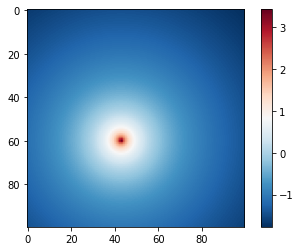

In [57]:
plt.imshow(np.log(kappa_ls), cmap="RdBu_r")
plt.colorbar()

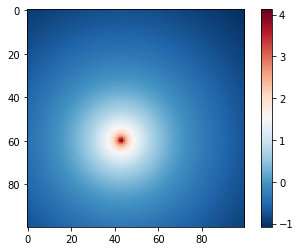

In [58]:
plt.imshow(kappa.log().numpy(), cmap="RdBu_r")
plt.colorbar()

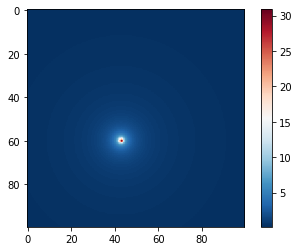

In [59]:
plt.imshow(kappa.numpy() - kappa_ls, cmap="RdBu_r")
plt.colorbar()

In [61]:
np.allclose(kappa.numpy(), kappa_ls, rtol=1e-5, atol=1e-5)

True

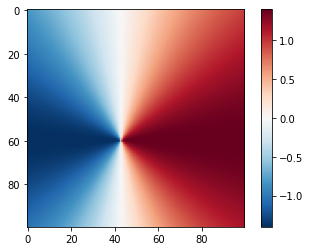

In [45]:
plt.imshow(alpha_x_ls, cmap="RdBu_r")
plt.colorbar()

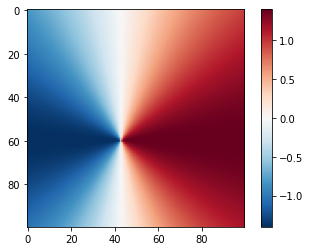

In [46]:
plt.imshow(alpha_x.numpy(), cmap="RdBu_r")
plt.colorbar()

In [47]:
np.allclose(alpha_x.numpy(), alpha_x_ls, rtol=1e-5, atol=1e-5)

True

In [48]:
np.allclose(alpha_y.numpy(), alpha_y_ls, rtol=1e-5, atol=1e-5)

True

## Point mass

In [33]:
cosmology = FlatLambdaCDMCosmology("cosmo")
lens = Point("pt", cosmology, torch.tensor(0.5))

print(lens)

z_s = torch.tensor(1.2)
x = torch.tensor([0.912, -0.442, 1.1])
alpha_x, alpha_y = lens.alpha(thx, thy, z_s, lens.x_to_dict(x))
Psi = lens.Psi(thx, thy, z_s, lens.x_to_dict(x))

Point(
    name='pt',
    static params=['z_l', 's', 'h0', 'rho_cr_0', 'Om0'],
    dynamic params=['thx0', 'thy0', 'th_ein']
)


In [34]:
# Lenstronomy setup
ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
kwargs_pixel = {
    "nx": n_pix,
    "ny": n_pix,  # number of pixels per axis
    "ra_at_xy_0": ra_at_xy_0,
    "dec_at_xy_0": dec_at_xy_0,
    "transform_pix2angle": transform_pix2angle,
}
pixel_grid = PixelGrid(**kwargs_pixel)
thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)

lens_model_list = ["POINT_MASS"]
lens_ls = LensModel(lens_model_list=lens_model_list)

# Parameters
kwargs_ls = [{"center_x": x[0].item(), "center_y": x[1].item(), "theta_E": x[2].item()}]

alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)
Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)

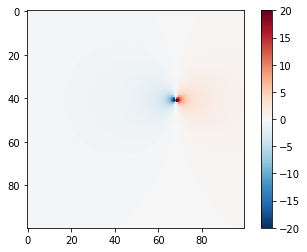

In [35]:
# plt.imshow(alpha_x.numpy(), cmap="RdBu_r")
plt.imshow(alpha_x_ls, cmap="RdBu_r", vmin=-20, vmax=20)
plt.colorbar()

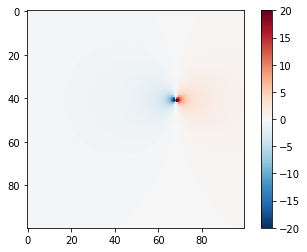

In [36]:
plt.imshow(alpha_x.numpy(), cmap="RdBu_r", vmin=-20, vmax=20)
# plt.imshow(alpha_x_ls, cmap="RdBu_r")
plt.colorbar()

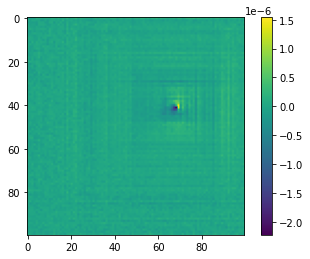

In [37]:
plt.imshow(Psi.numpy() - Psi_ls)
plt.colorbar()

In [38]:
np.allclose(Psi.numpy(), Psi_ls, rtol=1e-5, atol=1e-5)

True

In [39]:
np.allclose(alpha_x.numpy(), alpha_x_ls, rtol=1e-5, atol=1e-5)

True

In [40]:
np.allclose(alpha_y.numpy(), alpha_y_ls, rtol=1e-5, atol=1e-5)

True

## SIE

In [21]:
cosmology = FlatLambdaCDMCosmology("cosmo")
lens = SIE("sie", cosmology)

print(lens)

z_s = torch.tensor(1.2)
x = torch.tensor([0.5, 0.912, -0.442, 0.7, pi / 3, 1.4])
alpha_x, alpha_y = lens.alpha(thx, thy, z_s, lens.x_to_dict(x))
Psi = lens.Psi(thx, thy, z_s, lens.x_to_dict(x))

SIE(
    name='sie',
    static params=['s', 'h0', 'rho_cr_0', 'Om0'],
    dynamic params=['z_l', 'thx0', 'thy0', 'q', 'phi', 'b']
)


In [22]:
# Lenstronomy setup
ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
kwargs_pixel = {
    "nx": n_pix,
    "ny": n_pix,  # number of pixels per axis
    "ra_at_xy_0": ra_at_xy_0,
    "dec_at_xy_0": dec_at_xy_0,
    "transform_pix2angle": transform_pix2angle,
}
pixel_grid = PixelGrid(**kwargs_pixel)
thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)

lens_model_list = ["SIE"]
lens_ls = LensModel(lens_model_list=lens_model_list)

# Parameters
e1, e2 = param_util.phi_q2_ellipticity(phi=x[4].item(), q=x[3].item())
kwargs_ls = [
    {
        "theta_E": x[5].item(),
        "e1": e1,
        "e2": e2,
        "center_x": x[1].item(),
        "center_y": x[2].item(),
    }
]

alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)
Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)

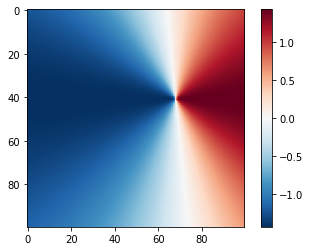

In [23]:
# plt.imshow(alpha_x.numpy(), cmap="RdBu_r")
plt.imshow(alpha_x_ls, cmap="RdBu_r")
plt.colorbar()

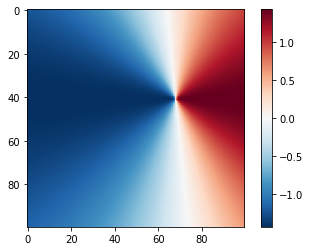

In [25]:
plt.imshow(alpha_x.numpy(), cmap="RdBu_r")
# plt.imshow(alpha_x_ls, cmap="RdBu_r")
plt.colorbar()

In [105]:
np.allclose(alpha_x.numpy(), alpha_x_ls, rtol=1e-5, atol=1e-5)

True

In [106]:
np.allclose(alpha_y.numpy(), alpha_y_ls, rtol=1e-5, atol=1e-5)

True

## EPL

In [123]:
cosmology = FlatLambdaCDMCosmology("cosmo")
lens = EPL("epl", cosmology)
print(lens)
z_s = torch.tensor(1.0)
x = torch.tensor([0.7, 0.912, -0.442, 0.7, pi / 3, 1.4, 1.35])
alpha_x, alpha_y = lens.alpha(thx, thy, z_s, lens.x_to_dict(x))
Psi = lens.Psi(thx, thy, z_s, lens.x_to_dict(x))

EPL(
    name='epl',
    static params=['s', 'h0', 'rho_cr_0', 'Om0'],
    dynamic params=['z_l', 'thx0', 'thy0', 'q', 'phi', 'b', 't']
)


In [124]:
lens_model_list = ["EPL"]
lens_ls = LensModel(lens_model_list=lens_model_list)

e1, e2 = param_util.phi_q2_ellipticity(phi=x[4].item(), q=x[3].item())
theta_E = (x[5] / x[3].sqrt()).item()
kwargs_ls = [
    {
        "theta_E": theta_E,
        "e1": e1,
        "e2": e2,
        "center_x": x[1].item(),
        "center_y": x[2].item(),
        "gamma": x[6].item() + 1,  # important: add +1
    }
]

alpha_x_ls, alpha_y_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)
Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)

In [129]:
lens.x_to_dict(x)

{'epl': tensor([ 0.7000,  0.9120, -0.4420,  0.7000,  1.0472,  1.4000,  1.3500]),
 'cosmo': tensor([])}

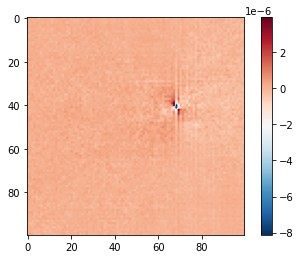

In [125]:
plt.imshow(alpha_x - alpha_x_ls, cmap="RdBu_r")
plt.colorbar()

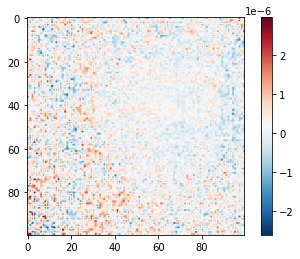

In [128]:
plt.imshow(Psi_ls - Psi.numpy(), cmap="RdBu_r")
plt.colorbar()

## Sersic

In [137]:
res = 0.05
nx = 200
ny = 200
thx, thy = get_meshgrid(res, nx, ny)
sersic = Sersic("sersic", use_lenstronomy_k=True)

In [144]:
# Lenstronomy setup
ra_at_xy_0, dec_at_xy_0 = (-5 + res / 2, -5 + res / 2)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
kwargs_pixel = {
    "nx": nx,
    "ny": ny,  # number of pixels per axis
    "ra_at_xy_0": ra_at_xy_0,
    "dec_at_xy_0": dec_at_xy_0,
    "transform_pix2angle": transform_pix2angle,
}
pixel_grid = PixelGrid(**kwargs_pixel)
source_light_model_list = ["SERSIC_ELLIPSE"]
sersic_ls = LightModel(light_model_list=source_light_model_list)

# Parameters
thx0_src = 0.05
thy0_src = 0.01
phi_src = 0.8
q_src = 0.5
index_src = 1.5
th_e_src = 0.1
I_e_src = 100
x = torch.tensor([thx0_src, thy0_src, q_src, phi_src, index_src, th_e_src, I_e_src])
e1, e2 = param_util.phi_q2_ellipticity(phi=phi_src, q=q_src)
kwargs_light_source = [
    {
        "amp": I_e_src,
        "R_sersic": th_e_src,
        "n_sersic": index_src,
        "e1": e1,
        "e2": e2,
        "center_x": thx0_src,
        "center_y": thy0_src,
    }
]

brightness = sersic.brightness(thx, thy, sersic.x_to_dict(x))
brightness_ls = sersic_ls.surface_brightness(
    *pixel_grid.coordinate_grid(nx, ny), kwargs_light_source
)

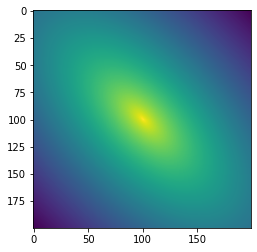

In [145]:
plt.imshow(np.log(brightness_ls))

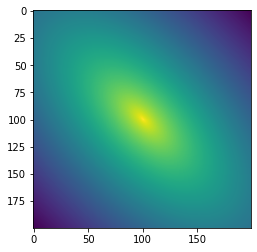

In [146]:
plt.imshow(brightness.log())